# Explaining SIM City Mechanics

...with examples.

This notebook serves to illustrate how the environment calculates pollution / population gain for every tile. And how each city tile affects other city tile.

This is different from `eaxmple_run.ipynb` as this notebook has no agent involvement or even indicate how the simulation is run. This is strictly on the scoring system and how each tile affects each other.

In [92]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
#let's import our pre-requisites packages
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch, Rectangle

from environments.environment import CityModel
from update_rules.update_rules import DefaultUpdateRules, DefaultUpdateRulesParameters
from agents.agent import CityPlanner
from utils import TileTypes

In [94]:
tile_colours_map = {
    TileTypes.BARREN: "#eea5a5",
    TileTypes.RESIDENCE: "#ffeb3b",
    TileTypes.GREENERY: "#4caf50",
    TileTypes.INDUSTRY: "#9e9e9e",
    TileTypes.SERVICE: "#2196f3",
    TileTypes.ROAD: "#424242",
}

#in case I add any new tiles
assert(len(TileTypes)==len(tile_colours_map))

tile_colours = [tile_colours_map[t] for t in TileTypes]
tile_names = [t.name for t in TileTypes]

#visualise function that will be used here
def visulise_graph(model, precision=1):
    #go go go AI chatbot

    # Fetch arrays
    tile = model.grid.tile._mesa_data
    pop_g = model.grid.pop_g._mesa_data
    poll_g = model.grid.poll_g._mesa_data

    # Discrete colormap setup for tile (ensure order is 0..max_type)
    max_type = max([t.value for t in TileTypes])
    color_list = [tile_colours_map.get(t, "#000000") for t in TileTypes]
    tile_cmap = ListedColormap(color_list)
    # Boundaries s.t. integers map cleanly to categories
    bounds = np.arange(-0.5, max_type + 1.5, 1)
    tile_norm = BoundaryNorm(bounds, tile_cmap.N)

    # Create figure and axes
    # Layout: 2 rows (1 for tile, 1 for pop_g/poll_g)
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

    ax_tile = fig.add_subplot(gs[0, :])
    im0 = ax_tile.imshow(tile, cmap=tile_cmap, norm=tile_norm, origin="upper", aspect="equal")
    ax_tile.set_title("Tile", fontsize=14)
    nx, ny = tile.shape
    ax_tile.set_xticks(np.arange(-0.5, ny, 1), minor=True)
    ax_tile.set_yticks(np.arange(-0.5, nx, 1), minor=True)
    ax_tile.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax_tile.tick_params(which="minor", bottom=False, left=False)
    ax_tile.set_xticks([])
    ax_tile.set_yticks([])

    # Build legend patches for tile types that actually appear
    legend_handles = [
        Patch(facecolor=tile_colours_map[t], edgecolor="none", label=t.name)
        for t in TileTypes
    ]
    ax_tile.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.12),
        ncol=len(legend_handles),  # one row
        frameon=False,
        title="Tile Types",
        fontsize=9,
        title_fontsize=10,
    )

    # --- Row 2: pop_g and poll_g ---
    ax_pop = fig.add_subplot(gs[1, 0])
    ax_poll = fig.add_subplot(gs[1, 1])

    # Population growth
    im1 = ax_pop.imshow(pop_g, cmap="viridis", origin="upper", aspect="equal")
    ax_pop.set_title("Population Growth (pop_g)", fontsize=12)
    ax_pop.set_xticks(np.arange(-0.5, pop_g.shape[0], 1), minor=True)
    ax_pop.set_yticks(np.arange(-0.5, pop_g.shape[1], 1), minor=True)
    ax_pop.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax_pop.tick_params(which="minor", bottom=False, left=False)
    ax_pop.set_xticks([])
    ax_pop.set_yticks([])
    fig.colorbar(im1, ax=ax_pop, shrink=0.85, label="pop_g")

    for i in range(pop_g.shape[0]):
        for j in range(pop_g.shape[1]):
            val = float(pop_g[i, j])
            if val>0:
                ax_pop.text(
                    j, i, f"{val:.{precision}f}",
                    ha="center", va="center",
                    color="red", fontsize=8, fontweight="bold"
                )

    # Pollution growth
    im2 = ax_poll.imshow(poll_g, cmap="viridis", origin="upper", aspect="equal")
    ax_poll.set_title("Pollution Growth (poll_g)", fontsize=12)
    ax_poll.set_xticks(np.arange(-0.5, poll_g.shape[0], 1), minor=True)
    ax_poll.set_yticks(np.arange(-0.5, poll_g.shape[1], 1), minor=True)
    ax_poll.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax_poll.tick_params(which="minor", bottom=False, left=False)
    ax_poll.set_xticks([])
    ax_poll.set_yticks([])
    fig.colorbar(im2, ax=ax_poll, shrink=0.85, label="poll_g")
    for i in range(poll_g.shape[0]):
        for j in range(poll_g.shape[1]):
            val = float(poll_g[i, j])
            if val>0:
                ax_poll.text(
                    j, i, f"{val:.{precision}f}",
                    ha="center", va="center",
                    color="red", fontsize=8, fontweight="bold"
                )
    plt.tight_layout()
    plt.show()

def visualise_road_tiles(model):
    #go go go AI chatbot
    road_sets = model.road_sets
    nrows, ncols = road_sets.shape
    font_min=6; font_max=16
    base = min( max( int(min(nrows, ncols) and 36 / max(nrows, ncols) * 10), font_min), font_max )

    fig_w = min(18, max(6, ncols * 0.5))
    fig_h = min(18, max(4, nrows * 0.5))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    
    ax.set_title("Road sets", fontsize=base+2)
    # Draw cells as empty white rectangles with black borders
    ax.set_xlim(-0.5, ncols - 0.5)
    ax.set_ylim(nrows - 0.5, -0.5)  # origin='upper' to match NumPy [row, col]
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    # Cell borders
    for i in range(nrows):
        for j in range(ncols):
            ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="black", linewidth=0.6))

    # Text overlay (numbers only)
    for i in range(nrows):
        for j in range(ncols):
            v = road_sets[i, j]
            if v<=0:
                continue
            s = "nan" if np.isnan(v) else int(v)
            ax.text(j, i, s, ha="center", va="center", color="red", fontsize=base, fontweight="bold")

    plt.tight_layout()
    plt.show()

In [95]:
#let's create our environment first
# with open("data/update_parameters/DefaultUpdateRule.json") as f:
#     default_rule_parameters = json.load(f)
    
#to keep things very consistent throughout, let's use predefined values. Makes it easier to change as well
default_rule_parameters = {
  "residence_population_increase": 30,
  "residence_poll_g": 1.5,
  "residence_pop_g": 1,
  "residence_walking_distance": 1,
  
  "greenery_poll_minus": 0.05,
  "greenery_pop_g": 2,
  "greenery_coverage": 2,
  
  "industry_poll_g": 1,
  "industry_pop_g": 8,
  "industry_coverage": 2,
  "industry_connectivity_initial_modifier": 0.02,
  "industry_connectivity_cap": 10,

  "service_poll_g": 5.0,
  "service_pop_g": 4.0,
  "service_pop_modifier": 0.2,
  "service_coverage": 2,
  "service_connectivity_initial_modifier":0.05,
  "service_connectivity_cap": 5,
  
  "road_poll_g": 1,
  "road_pop_g": 0.5
}

default_rule_parameters = DefaultUpdateRulesParameters(**default_rule_parameters)

# define the class with empty parameters and set the parameters thereafter. 
# In case for extensions, one can override the parameters
update_rules = DefaultUpdateRules()
update_rules.set_parameters(default_rule_parameters)

#shouldn't do this but since we are not using any agent in the first place
width = 16
height = 16
model = CityModel(CityPlanner, width, height, update_rules, collect_rate=1.0)

## The Basics

We want to do urban planning with sustainability in mind. To this mind, we have an urban city discretised into a grid. For each turn, we will place a city tile on the grid, depending on the type of tile, it will produce pollution and/or population. The objective is to maximise population, and minimise pollution.

In the beginning, we have nothing but Barren land which produces 0 pollution and population.

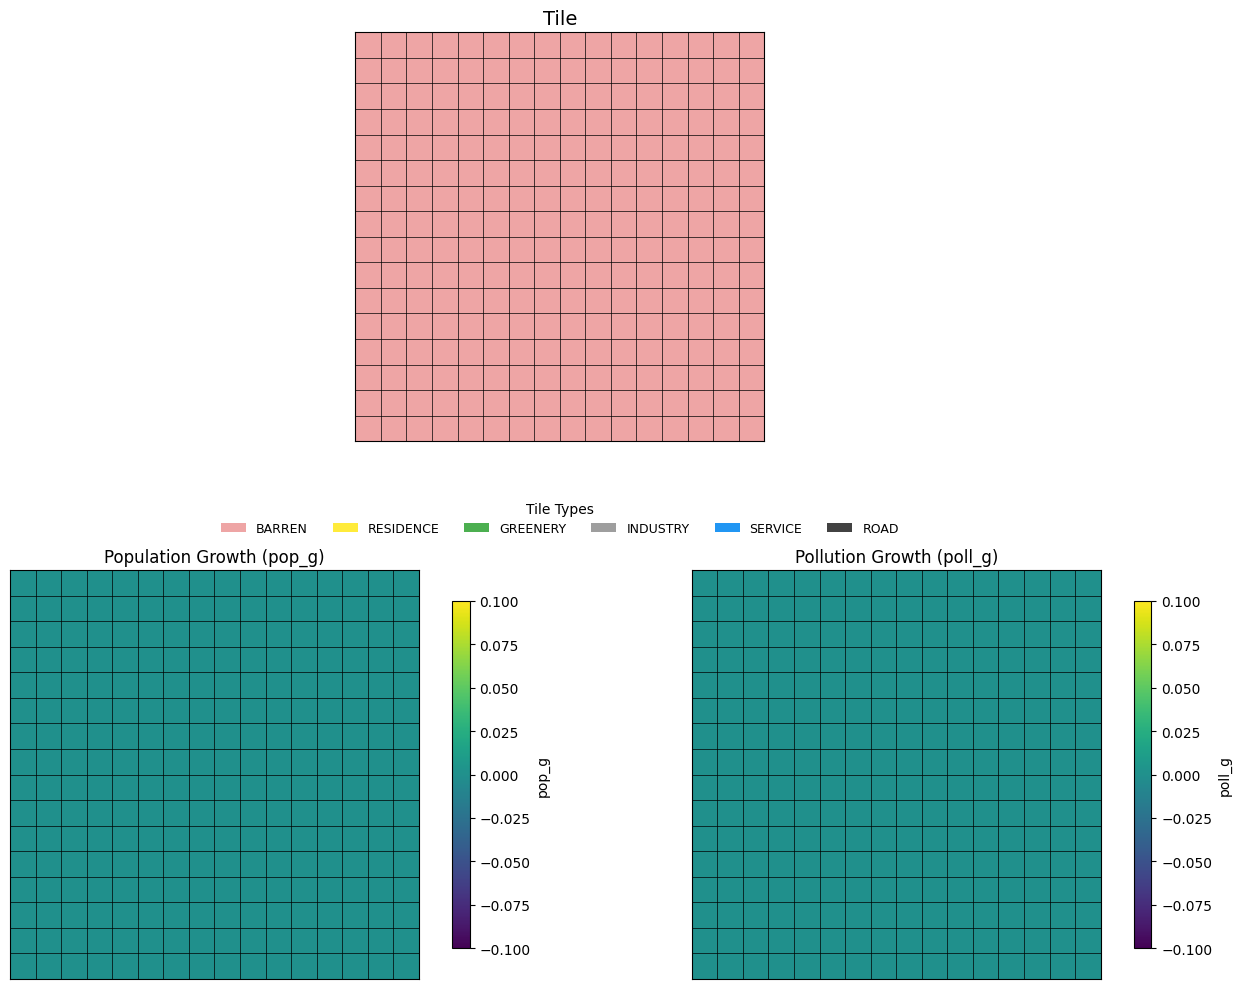

In [96]:
visulise_graph(model)

## Residence 

Residence tile represents liveability of a city. They produce population and pollution, their main function is to increase the population cap of the city. If your population cap is too low, the total population will be capped. 

Let's add some residence tiles around. Note in the simulation, each tile is placed at a time.

In [97]:
model.set_tile(2, 3,TileTypes.RESIDENCE.value)
model.set_tile(5, 12,TileTypes.RESIDENCE.value)
model.set_tile(12, 2,TileTypes.RESIDENCE.value)
model.set_tile(10, 10,TileTypes.RESIDENCE.value)
model.set_tile(7, 6,TileTypes.RESIDENCE.value)
model.set_tile(11, 3,TileTypes.RESIDENCE.value)

#this method must be invoked as it will consolidate the different tiles into seperate binary 
#numpy array
model.book_keep()

# we will need to invoke the update rules to update the population / pollution gain
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)
print(f"Current Population cap: {population_cap}")

Industry 1
Done
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Current Population cap: 180


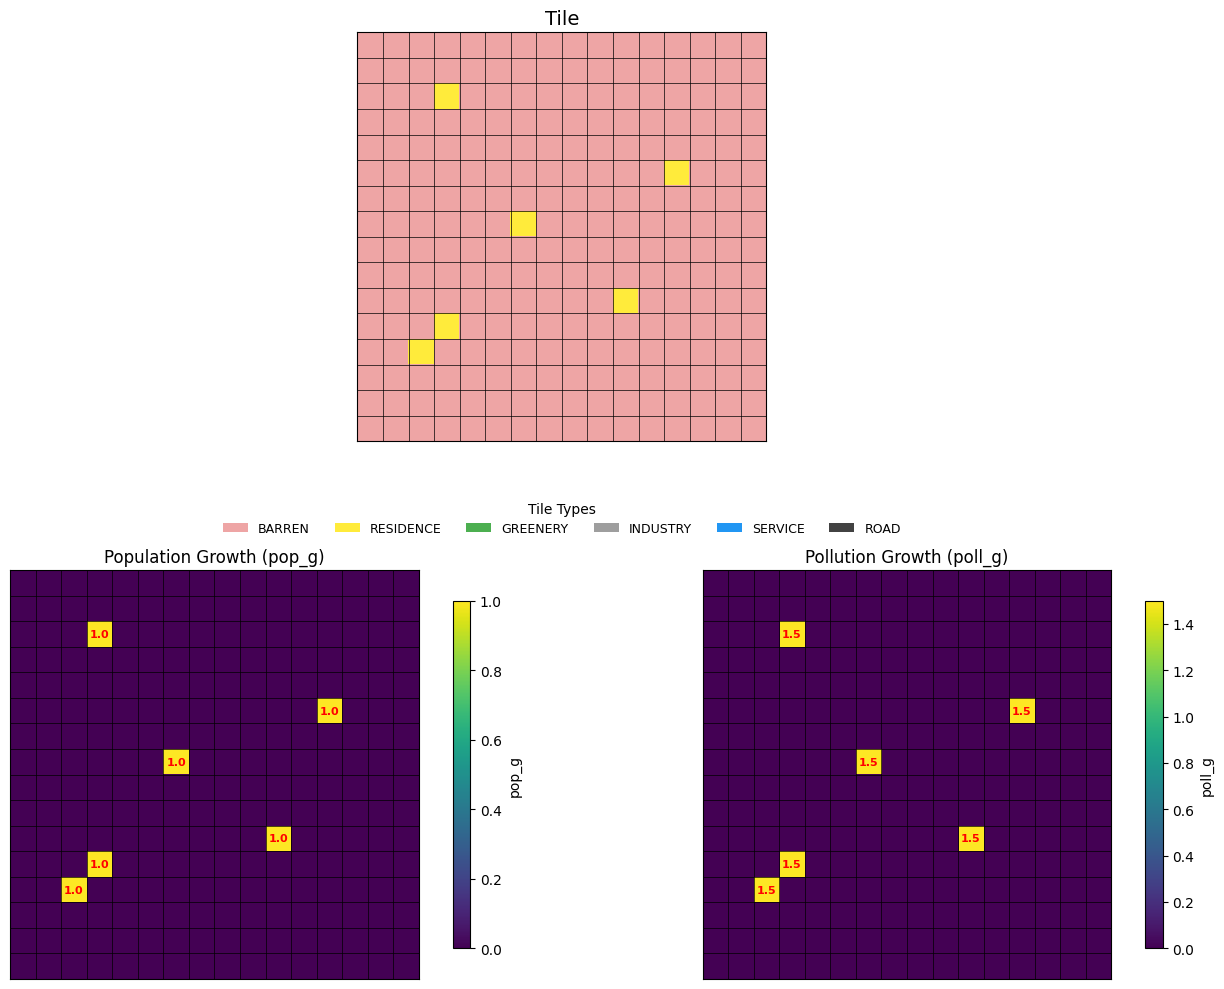

In [98]:
visulise_graph(model)

## Road

Road represent amenities and connectivity within the city. Roads don't produce much population but it produces quite a bit pollution. The main function of the road is to connect Residence tiles to Service and Industry tiles. Road tiles are connected only via **top, bottom, left and right neighbours (not adjacent)**. Each connected road tiles will form a network so it is possible to have different networks that are disconnected.

In [99]:
# let's add some preliminary network

model.set_tile(12, 6,TileTypes.ROAD.value)
model.set_tile(12, 5,TileTypes.ROAD.value)
model.set_tile(12, 4,TileTypes.ROAD.value)
model.set_tile(12, 3,TileTypes.ROAD.value)
model.set_tile(10, 8,TileTypes.ROAD.value)
model.set_tile(10, 7,TileTypes.ROAD.value)
model.set_tile(10, 6,TileTypes.ROAD.value)
model.set_tile(9, 6,TileTypes.ROAD.value)
model.set_tile(8, 10,TileTypes.ROAD.value)
model.set_tile(8, 11,TileTypes.ROAD.value)
model.set_tile(8, 12,TileTypes.ROAD.value)
model.set_tile(8, 13,TileTypes.ROAD.value)
model.set_tile(7, 14,TileTypes.ROAD.value)
model.set_tile(6, 14,TileTypes.ROAD.value)
model.set_tile(5, 14,TileTypes.ROAD.value)
model.set_tile(4, 14,TileTypes.ROAD.value)
model.set_tile(3, 8,TileTypes.ROAD.value)
model.set_tile(2, 8,TileTypes.ROAD.value)
model.set_tile(2, 7,TileTypes.ROAD.value)
model.set_tile(2, 6,TileTypes.ROAD.value)
model.set_tile(2, 5,TileTypes.ROAD.value)
model.set_tile(2, 4,TileTypes.ROAD.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

Industry 1
Done
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


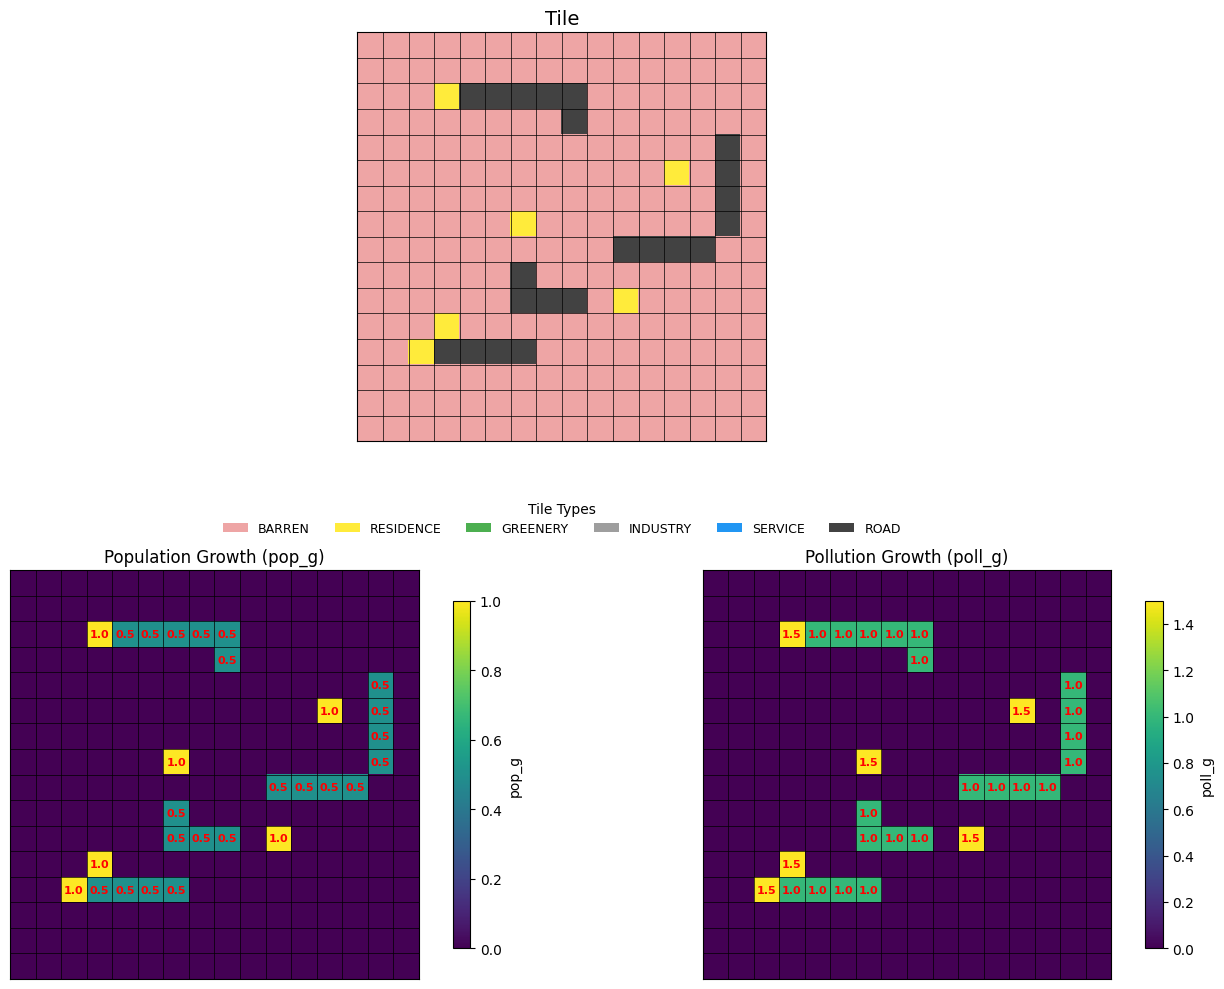

In [100]:
visulise_graph(model)

We can also visualise its road "network" as well. Network in quotes because it's really more of assigning ids to each road tiles. Tile with the same id belongs to the same network. You will note that roads that are diagonal to each other are not counted (Road network 3 and 4)

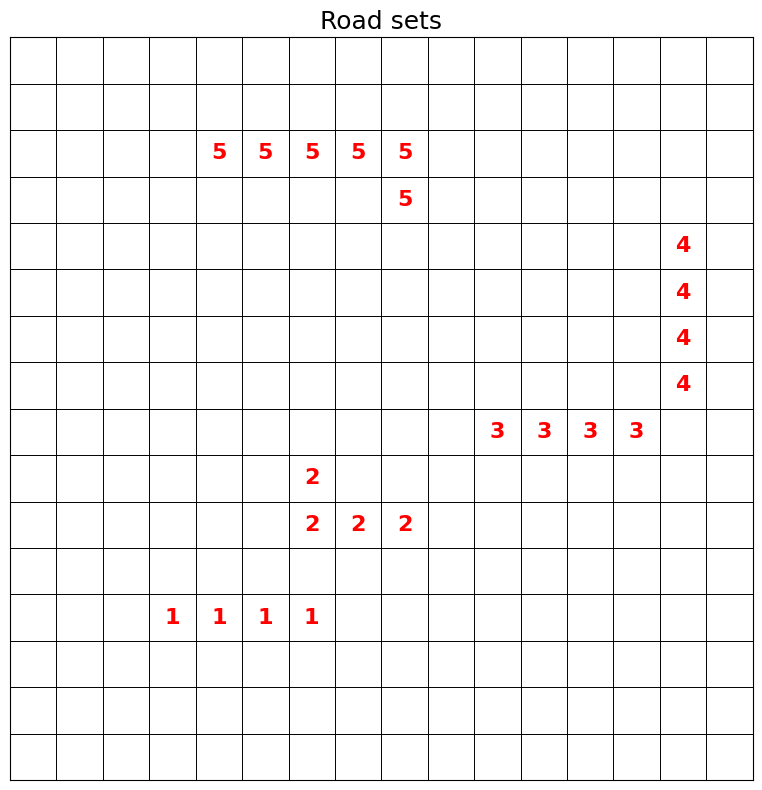

In [101]:
visualise_road_tiles(model)

Road networks can be merged. Smaller networks are subsumed into bigger network. Let's first add one more road time to network 4. Then merge 3 and 4 together

Industry 1
Done
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


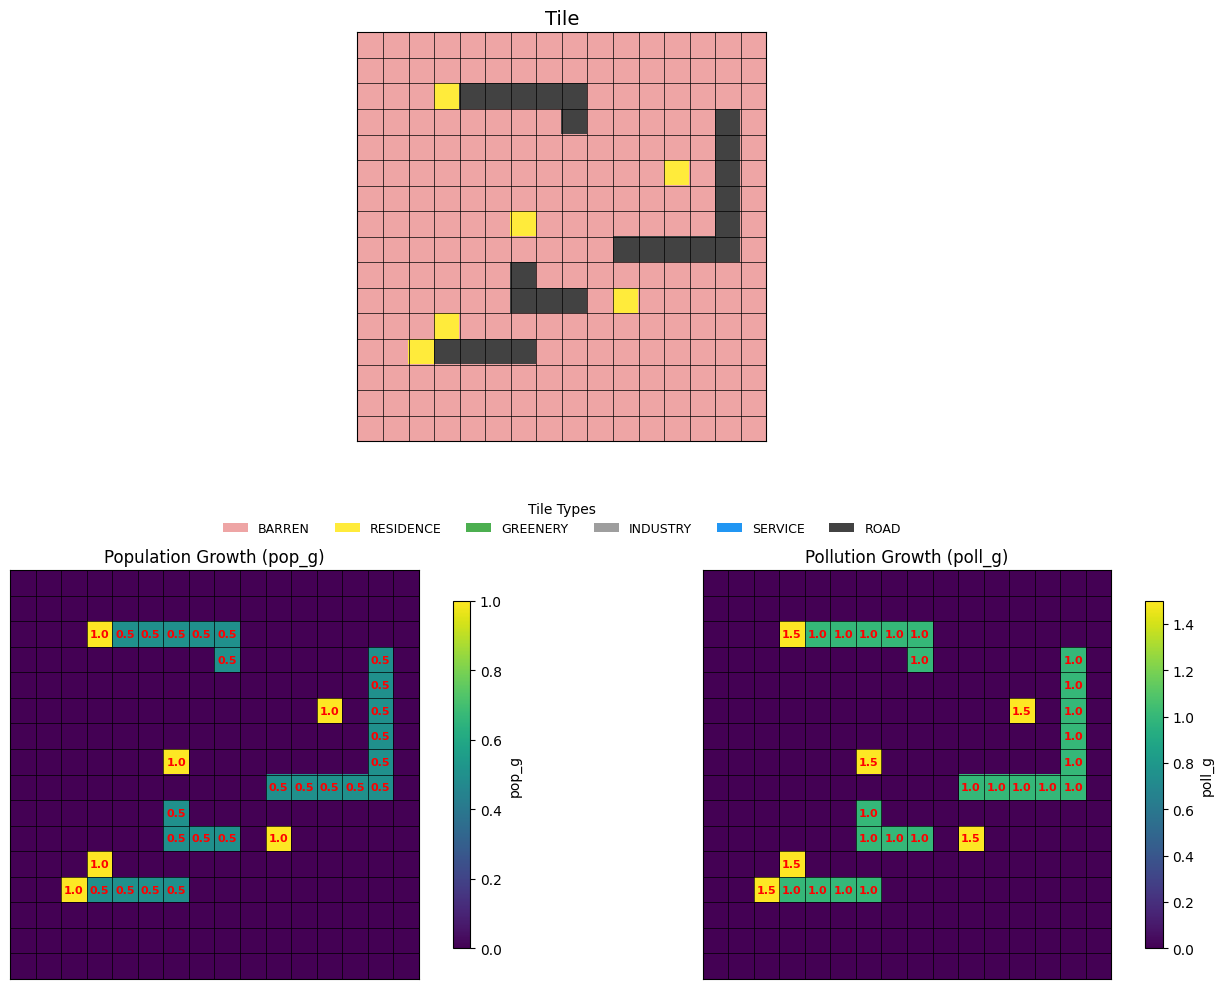

In [102]:
model.set_tile(3, 14,TileTypes.ROAD.value)
model.set_tile(8, 14,TileTypes.ROAD.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

visulise_graph(model)

Visualising the road IDs, we can see that 3 is gone and merged into 4 as it has more road tiles.

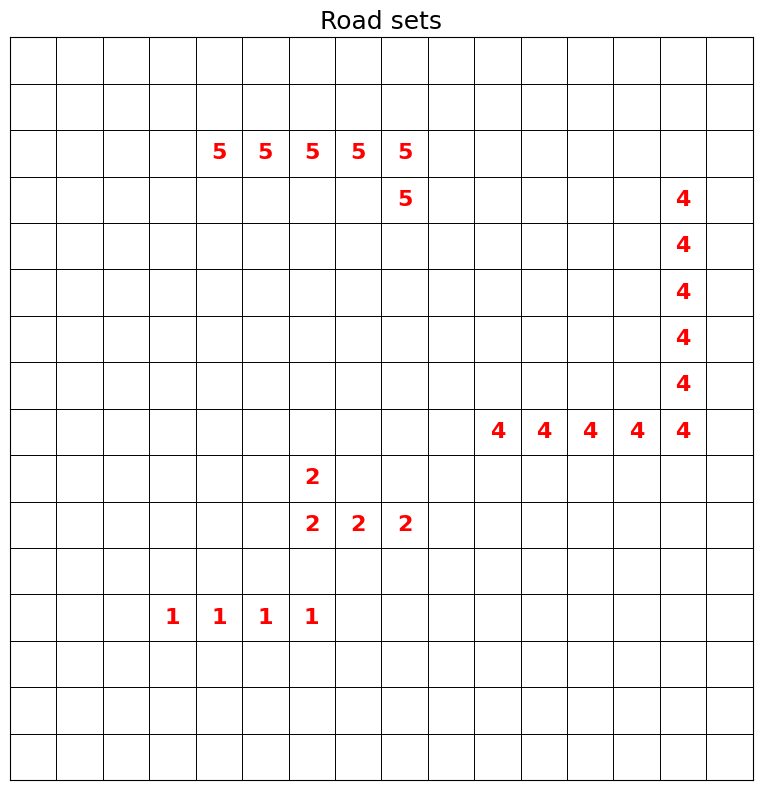

In [103]:
visualise_road_tiles(model)

### Road connectivity

Under the hood, the environment will keep track which Residence tiles are connected to which Road network. During merging, residences associated with smaller road networks will be associated with the larger network as well. Note, a resident tile can also be associated with multiple road networks. 

# Services

Services represent amenities, this could range from entertainment to essential services. They boost population and contribute quite a bit to pollution. Services require connections to residence in order to be 'productive', in this case reach its 100% population and pollution contribution.

Below, show how population and pollution of each service tile is calculated. 

$Population(service\ tile) = (x_{service} + \frac{1-x_{service}}{s_{cap}} \cdot r_{s_c}) \cdot s_{pop}$

$Pollution(service\ tile) = (x_{service}  + \frac{1-x_{service}}{s_{cap}} \cdot r_{s_c}) \cdot s_{poll}$

where:
- $x<1$, this is defined under `service_connectivity_initial_modifier` in the rule parameters
- $s_{pop}$ and $s_{poll}$ are a service tile's base value for population and pollution respectively. `service_pop_g` and `service_poll_g` under rule parameters respectively.
- $s_{cap}$ is the number of residence tiles needed before a tile reach 100% 'productivity'. Defined under `service_connectivity_cap` under rule parameters.
- $r_{s_c}$ is the number of residence tiles currently connected via roads _and_ any residences within walking distance. 
- Typically, $x<\frac{1-x_{service}}{s_{cap}}$

Note:
- this means if there are no Residence tiles connected, it is simply $x\cdot s_{pop}$  and $x\cdot s_{poll}$  
- when $r_c = s_{cap}$, $Population(service\ tile) = s_{pop}$, thus, 100% productivity.
- when $r_c > s_{cap}$, the service tile becomes more productive which produces more population and pollution.

A special thing about services tile is that is boost surrounding Residence tiles to simulate that these residences are attractive as they are near such amenities. Surrounding residences in this case depends on the `service_coverage` and the `service_pop_modifier`. This modifier stacks! So the more services surrounding multiple 

Let's define some service tiles.


Industry 1
Done
0.05 3 0.19
0.05 2 0.19
0.05 6 0.19
0.05 0 0.19
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


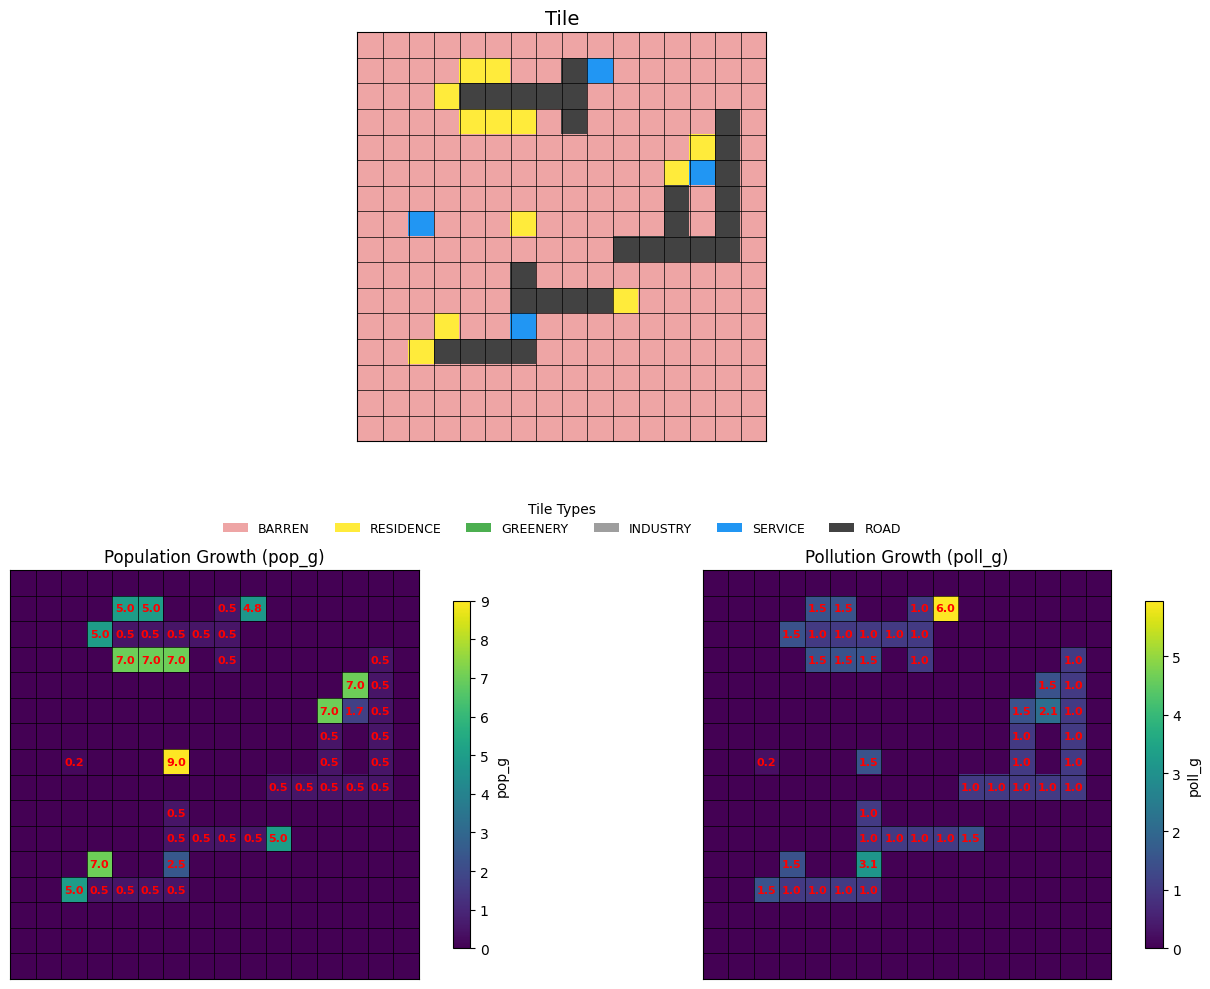

In [ ]:
#let's complete some network first
model.set_tile(7, 12,TileTypes.ROAD.value)
model.set_tile(6, 12,TileTypes.ROAD.value)
model.set_tile(10, 9,TileTypes.ROAD.value)
model.set_tile(4, 13,TileTypes.RESIDENCE.value)

model.set_tile(11, 6,TileTypes.SERVICE.value)
model.set_tile(5, 13,TileTypes.SERVICE.value)
model.set_tile(7, 2,TileTypes.SERVICE.value)

#let's add a very well connected residence
model.set_tile(3, 6,TileTypes.RESIDENCE.value)
model.set_tile(3, 5,TileTypes.RESIDENCE.value)
model.set_tile(3, 4,TileTypes.RESIDENCE.value)
model.set_tile(1, 5,TileTypes.RESIDENCE.value)
model.set_tile(1, 4,TileTypes.RESIDENCE.value)
model.set_tile(1, 8,TileTypes.ROAD.value)
model.set_tile(1, 9,TileTypes.SERVICE.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

visulise_graph(model, precision=2)

As you can see above, the only service tile that is standalone only produces $0.05 \times 4=0.2$ population, whereas the other two services are each connected to two residences:  $(0.05+\frac{1-0.05}{5} \times 2 \times 4)=1.7$.The same applies to pollution albeit with different pollution base.

We can also see that some residence tiles have improved population yield with `service_pop_modifier=1.2` and `service_coverage=2`. The two residence tiles at the upper right have $1\times 1.2=1.2$ population compared to other residence of $1.0$ population.

The one service tile connected to 6 residence tiles has a yield of $(0.05+\frac{1-0.05}{5} \times 6 \times 4)=4.76$ population

# Industry

Industry represents job opportunities of the city. They produce the greatest amount of population but also pollution. Like services, their productivity depends on how well connected they are, and in fact follow the same formula albeit governed by their own parameter

$Population(industry\ tile) = (x_{industry} + \frac{1-x_{industry}}{i_{cap}} \cdot r_{i_c}) \cdot i_{pop}$

$Pollution(industry\ tile) = (x_{industry} + \frac{1-x_{industry}}{i_{cap}} \cdot r_{i_c}) \cdot i_{poll}$


Industry has a special mechanics where its pollution spread across surrounding cell defined by `industry_coverage`. Thus $$Pollution(industry\ tile)$ defines the pollution of _each_ cell so do take note when tweaking `industry_poll_g`

Like service tiles, the more residence connected, the more productive the industry tile. 

Industry 1
0.02 2 0.098
Done
0.05 3 0.19
0.05 2 0.19
0.05 6 0.19
0.05 0 0.19
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


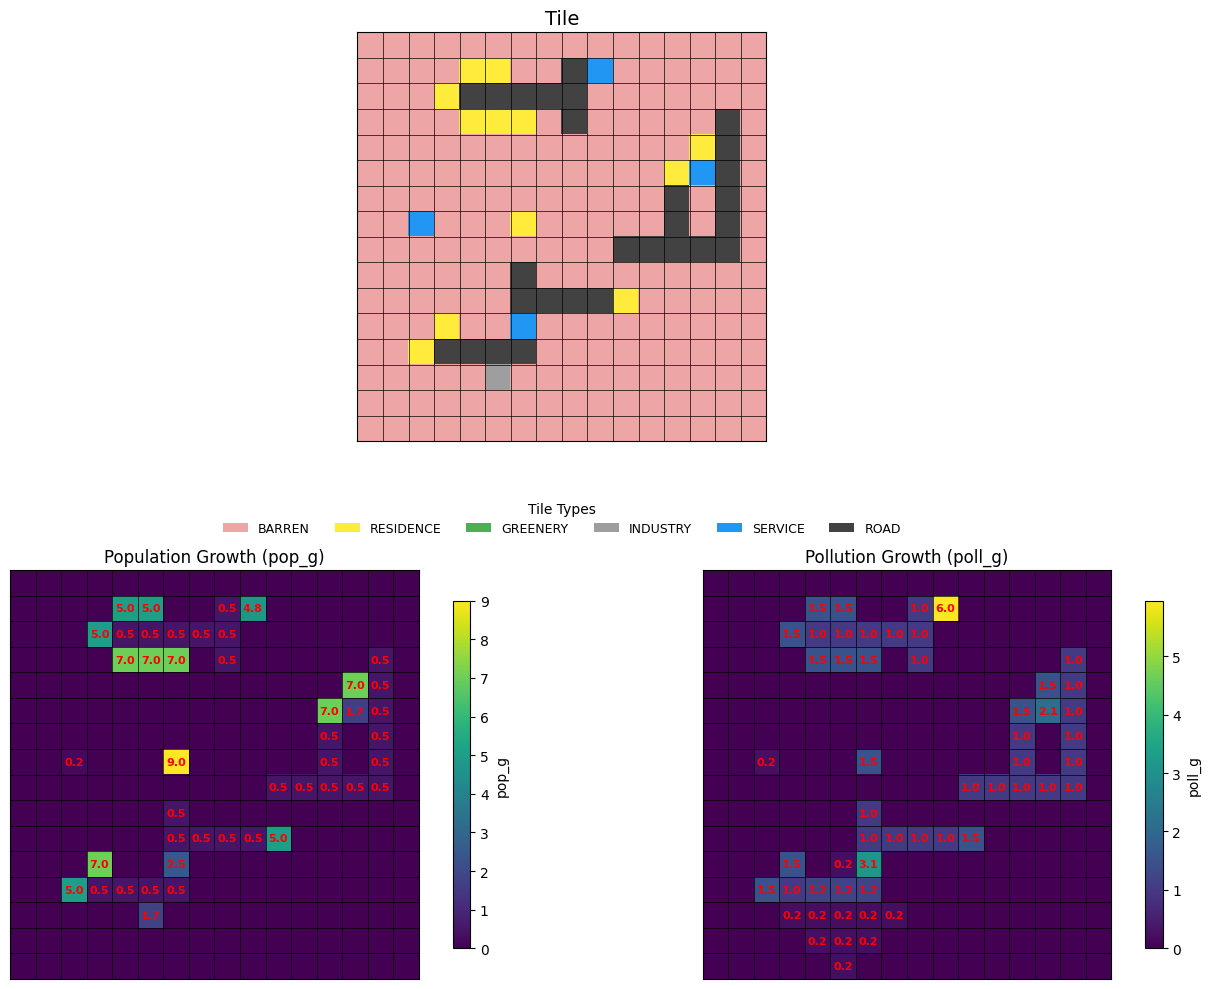

In [105]:
model.set_tile(13, 5,TileTypes.INDUSTRY.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

visulise_graph(model)

In the above example:

$Pollution(industry\ tile) = (x_{industry} + \frac{1-x_{industry}}{i_{cap}} \cdot r_{i_c}) \cdot i_{poll}$

- $x_{industry}=0.02$
- $i_{cap}=10$
- $i_{poll}=1$
- $r_{i_c} = 2$

Thus, $Pollution(industry\ tile) = 0.216$

With `industry_coverage=2`, we see a cross-shaped like spread, with each tile having pollution of 0.216. Note also the pollution gain is added to the road tiles. 

# Greenery

Greenery tile represents the livability of the city and is also the only mechanism to mitigate pollution. They also add to population.

The pollution is mitigated after all population is calculated (basically greenery is the last to calculate for pollution). The formula is as followed:

$Pollution(tile)\cdot\frac{1}{(1+\sum_n g_p)}$

Where:
- $g_p$ is defined under `greenery_poll_minus`, $0<g_p<1,$ 
- $n$ is the number of overlapping coverage. So if two greenery covers a tile, $n=2$. Coverage is determined by `greenery_coverage`

Basically, the more greenery overlaps on a tile, the more pollution it mititgates. Note that it will never be less than 0.

Industry 1
0.02 2 0.098
Done
0.05 3 0.19
0.05 2 0.19
0.05 6 0.19
0.05 0 0.19
[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.90909091 0.90909091 0.90909091 0.90909091 0.90909091 0.90909091
  0.90909091 0.90909091 0.90909091 0.90909091 0.90909091 0.90909091
  0.90909091 0.90909091 0.90909091 0.90909091]
 [0.86956522 0.86956522 0.86956522 0.86956522 0.86956522 0.86956522
  0.86956522 0.86956522 0.86956522 0.86956522 0.86956522 0.86956522
  0.86956522 0.86956522 0.86956522 0.86956522]
 [0.76923077 0.76923077 0.76923077 0.76923077 0.76923077 0.76923077
  0.76923077 0.76923077 0.76923077 0.76923077 0.76923077 0.76923077
  0.76923077 0.76923077 0.76923077 0.76923077]
 [0.76923077 0.76923077 0.76923077 0.769

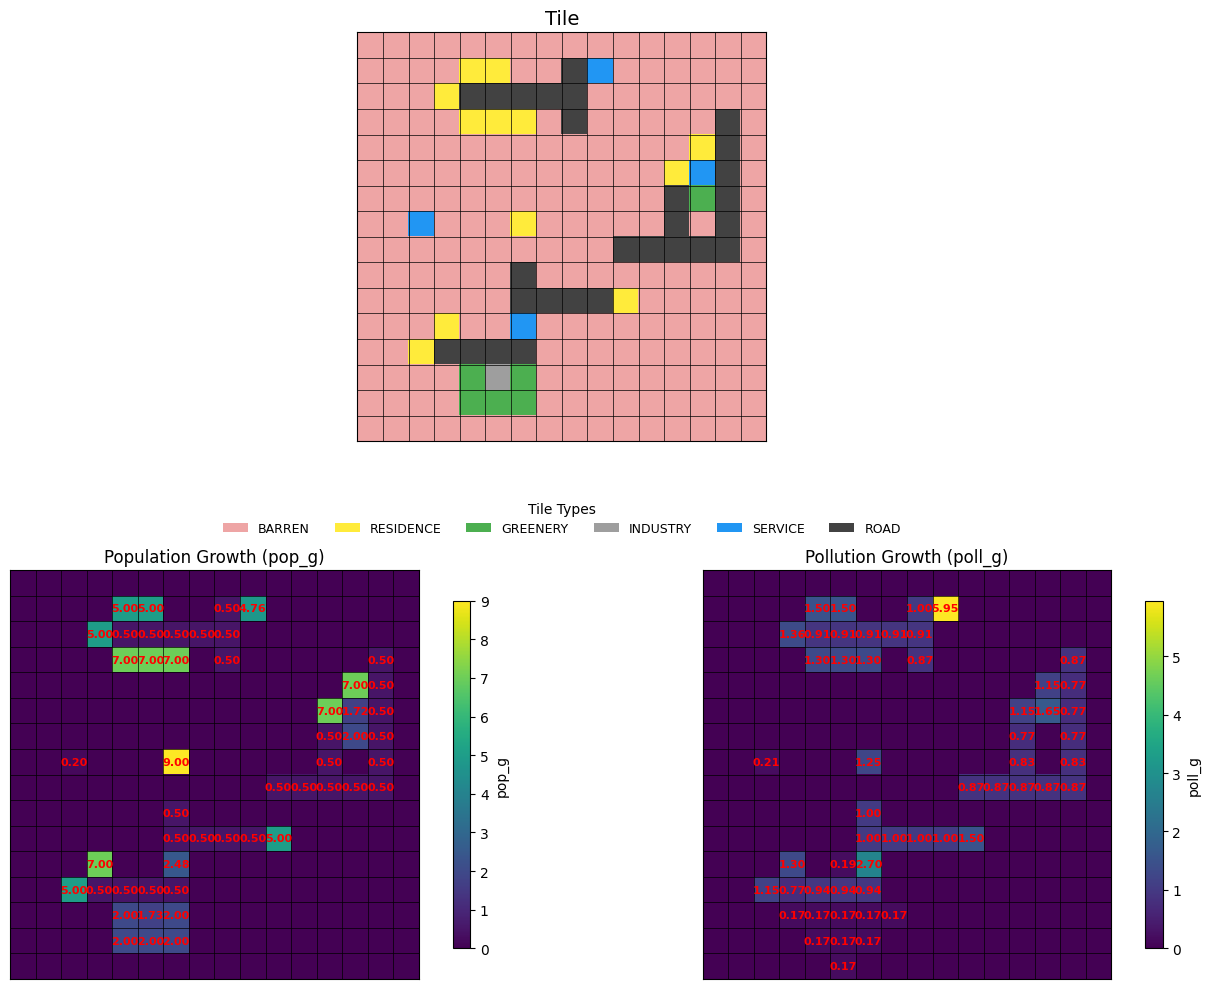

In [106]:
model.set_tile(13, 4,TileTypes.GREENERY.value)
model.set_tile(13, 6,TileTypes.GREENERY.value)
model.set_tile(14, 4,TileTypes.GREENERY.value)
model.set_tile(14, 6,TileTypes.GREENERY.value)
model.set_tile(14, 4,TileTypes.GREENERY.value)
model.set_tile(14, 5,TileTypes.GREENERY.value)
model.set_tile(6, 13,TileTypes.GREENERY.value)
model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

visulise_graph(model, precision=2)

While, 

Destroying a tile

- Only activated when tile=barren
- Update road network
- If (x,y) is road, check to see if it breaks its network.
- Road network is broken is (x,y) is considered part of vertex cut. 
- Can see it as a graph disconectivity issue 